# Deep Learning NER task

Tatjana Cucic and Sanna Volanen

https://spacy.io/api/annotation

# Milestones

## 1.1 Predicting word labels independently

* The first part is to train a classifier which assigns a label for each given input word independently. 
* Evaluate the results on token level and entity level. 
* Report your results with different network hyperparameters. 
* Also discuss whether the token level accuracy is a reasonable metric.









In [1]:
# Training data: Used for training the model
#!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/train.tsv

# Development/ validation data: Used for testing different model parameters, for example level of regularization needed
#!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/dev.tsv

# Test data: Never touched during training / model development, used for evaluating the final model
#!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/test.tsv

#saved model
#!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/saved_models/Adamax90.h5



In [1]:
import sys 
import csv

#csv.field_size_limit(sys.maxsize)
csv.field_size_limit(2147483647)

131072

In [2]:
import os
os.chdir('C:\\Users\\Tanja\\Desktop\\NER')

In [3]:
#read tsv data to list of lists of lists: a list of sentences that contain lists of tokens that are lists of unsplit \t lines from the tsv, such as ['attract\tO']
token = {"word":"","entity_label":""}

def read_ontonotes(tsv_file): # 
    current_sent = [] # list of (word,label) lists
    #with open(tsv_file) as f:
    with open(tsv_file, "r", encoding="utf-8") as f:
        tsvreader = csv.reader(f, delimiter= '\n')
        for line in tsvreader:
            #print(line)
            if not line:
                if current_sent:
                    yield current_sent
                    current_sent=[]
                continue
            current_sent.append(line[0]) 
        else:
            if current_sent:
                yield current_sent

train_data_full = list(read_ontonotes('train.tsv'))
dev_data_full = list(read_ontonotes('dev.tsv'))
test_data_full = list(read_ontonotes('test.tsv'))

In [5]:
train_data_full[7]

['And\tO',
 'what\tO',
 'effect\tO',
 'does\tO',
 'their\tO',
 'return\tO',
 'have\tO',
 'on\tO',
 'campus\tO',
 '?\tO']

In [6]:
import re
from pprint import pprint
#regex for empty space chars, \t \n
tab = re.compile('[\t]')
line = re.compile('[\n]')
punct = re.compile('[.?!:;]')

def splitter(sent):
    #print('----------------------------------------')
    #print("one sentence in raw data:", sent)
    split_list = []
    # loop over tokens items inside sentence, supposedly item= token+ \t +tag
    for item in sent: 
        #print("Item in sentence: ", item)
        if item != None:
            match1 = item.count('\n')
            #print(match1)
            match2 = item.count('\t')
            #print(match2)
            if match1 ==0: # no new lines nested
                if match2 == 1: #just one tab inside token
                    item_pair = item.split('\t')
                if item_pair[0] =='': # replacing empty string with missing quote marks
                    item_pair[0] = '\"'
                split_list.append(item_pair) 
            else:
                subitems_list = item.split('\n') ## check if token has \n -> bundled, quotes
                if len(subitems_list) > 1:  ## item string has more than one sentence nested in it
                    #print("Found nested sentences: ", subitems_list)
                    #print("subseq start")
                    for j in range(len(subitems_list)):  
                        token = subitems_list[j]  
                        #print(token)
                        subtoken_listed_again = token.split('\n') 
                        for token in subtoken_listed_again:
                            match1=token.count('\n')
                            match2=token.count('\t')
                            if  match1 == 0: # no new lines nested
                               if  match2 == 1: #just one tab inside token
                                    token = token.split('\t')
                            if token =='': # replacing empty string with missing quote marks
                                token = '\"'
                            if token == '.':
                                split_list.append(token)
                                continue
                                split_list=[]
                            else:
                                split_list.append(token)
                    #print("subseq end")
    for item in split_list:
        #print("Item in split list: ",item)
        if type(item) != list:
            split_list.remove(item)
        if item[0] =='': # replacing empty string with missing quote marks
            item[0] = '\"'
    #print("Resplitted sentence :", split_list)
    return split_list

def clean(raw_data): ## input list is list of lists of strings 
    clean_data =[]  #list of lists that have one clean sentence per list
    for sent in raw_data: # split by [] lines, supposedly a sentence line
        one_sentence = [] #collects the new sentence if there has been need to resplit items
        splitted= splitter(sent)
        for item in splitted:
            #print(item)
            matchi = re.match(punct, item[0])
            if matchi:
                #print("collected sentence")
                one_sentence.append(item)
                clean_data.append(one_sentence)
                one_sentence=[]
                break
            else:
                one_sentence.append(item)

    return clean_data

train_data_clean = clean(train_data_full)
print(len(train_data_clean))
for item in train_data_clean[:3]:
    print(item)

50252
[['In', 'O'], ['recent', 'B-DATE'], ['years', 'I-DATE'], [',', 'O'], ['advanced', 'O'], ['education', 'O'], ['for', 'O'], ['professionals', 'O'], ['has', 'O'], ['become', 'O'], ['a', 'O'], ['hot', 'O'], ['topic', 'O'], ['in', 'O'], ['the', 'O'], ['business', 'O'], ['community', 'O'], ['.', 'O']]
[['With', 'O'], ['this', 'O'], ['trend', 'O'], [',', 'O'], ['suddenly', 'O'], ['the', 'O'], ['mature', 'O'], ['faces', 'O'], ['of', 'O'], ['managers', 'O'], ['boasting', 'O'], ['an', 'O'], ['average', 'O'], ['of', 'O'], ['over', 'O'], ['ten', 'B-DATE'], ['years', 'I-DATE'], ['of', 'O'], ['professional', 'O'], ['experience', 'O'], ['have', 'O'], ['flooded', 'O'], ['in', 'O'], ['among', 'O'], ['the', 'O'], ['young', 'O'], ['people', 'O'], ['populating', 'O'], ['university', 'O'], ['campuses', 'O'], ['.', 'O']]
[['In', 'O'], ['order', 'O'], ['to', 'O'], ['attract', 'O'], ['this', 'O'], ['group', 'O'], ['of', 'O'], ['seasoned', 'O'], ['adults', 'O'], ['pulling', 'O'], ['in', 'O'], ['over', 'O

In [7]:
# final check on the sentences
item_lengths = []
max_text = 0
for item in train_data_clean:
    item_lengths.append(len(item))
    if len(item) > max_text:
        max_text = len(item)
        ind = train_data_clean.index(item)
print("Longest sentence:", max_text, "index: ",ind)

lengths_sorted = sorted(item_lengths, reverse=True)
max = item_lengths.index(max_text)
#print(items_sorted[0])
#pprint(train_data_clean[max])
print(lengths_sorted[:300]) # longest sentences
# checking long items
#for item in train_data_clean:
    #if len(item) == 123:
        #pprint(item)

Longest sentence: 168 index:  8041
[168, 145, 123, 121, 120, 108, 106, 106, 102, 101, 97, 96, 94, 94, 93, 93, 93, 92, 91, 91, 91, 90, 90, 90, 90, 90, 90, 89, 88, 88, 88, 87, 87, 86, 85, 85, 85, 85, 84, 84, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 81, 81, 80, 80, 80, 79, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 77, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64

In [8]:
import numpy as np   #want to see the longest sentence

lengths = np.array(item_lengths)
train_data_clean[np.argmax(lengths)]

[['A', 'O'],
 ['rational', 'O'],
 ['approach', 'O'],
 ['to', 'O'],
 ['transportation', 'O'],
 ['would', 'O'],
 ['entail', 'O'],
 ['(', 'O'],
 ['1', 'O'],
 [')', 'O'],
 ['creating', 'O'],
 ['communities', 'O'],
 ['with', 'O'],
 ['a', 'O'],
 ['mix', 'O'],
 ['of', 'O'],
 ['housing', 'O'],
 ['/', 'O'],
 ['office', 'O'],
 ['/', 'O'],
 ['retail', 'O'],
 ['/', 'O'],
 ['amenities', 'O'],
 ['to', 'O'],
 ['reduce', 'O'],
 ['the', 'O'],
 ['number', 'O'],
 ['and', 'O'],
 ['length', 'O'],
 ['of', 'O'],
 ['automobile', 'O'],
 ['trips', 'O'],
 [',', 'O'],
 ['(', 'O'],
 ['2', 'O'],
 [')', 'O'],
 ['reforming', 'O'],
 ['counterproductive', 'O'],
 ['zoning', 'O'],
 ['codes', 'O'],
 [',', 'O'],
 ['subdivision', 'O'],
 ['ordinances', 'O'],
 ['and', 'O'],
 ['comprehensive', 'O'],
 ['plans', 'O'],
 ['in', 'O'],
 ['order', 'O'],
 ['to', 'O'],
 ['create', 'O'],
 ['more', 'O'],
 ['transit', 'O'],
 ['-', 'O'],
 ['friendly', 'O'],
 ['and', 'O'],
 ['pedestrian', 'O'],
 ['-', 'O'],
 ['friendly', 'O'],
 ['communitie

In [9]:
train_data_clean[0]

[['In', 'O'],
 ['recent', 'B-DATE'],
 ['years', 'I-DATE'],
 [',', 'O'],
 ['advanced', 'O'],
 ['education', 'O'],
 ['for', 'O'],
 ['professionals', 'O'],
 ['has', 'O'],
 ['become', 'O'],
 ['a', 'O'],
 ['hot', 'O'],
 ['topic', 'O'],
 ['in', 'O'],
 ['the', 'O'],
 ['business', 'O'],
 ['community', 'O'],
 ['.', 'O']]

In [10]:

print('------------------------------------------')
dev_data_clean = clean(dev_data_full)
print(len(dev_data_clean))
for item in dev_data_clean[:3]:
    print(item)
print('------------------------------------------')
test_data_clean = clean(test_data_full)
print(len(test_data_clean))
for item in test_data_clean[:3]:
    print(item)
print('------------------------------------------')    

------------------------------------------
9954
[['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['visited', 'O'], ['the', 'B-FAC'], ['Nicaraguan', 'I-FAC'], ['National', 'I-FAC'], ['Assembly', 'I-FAC'], ['on', 'O'], ['August', 'B-DATE'], ['17', 'I-DATE'], [',', 'O'], ['where', 'O'], ['he', 'O'], ['received', 'O'], ['a', 'O'], ['medal', 'O'], ['from', 'O'], ['the', 'O'], ['president', 'O'], ['of', 'O'], ['the', 'O'], ['assembly', 'O'], [',', 'O'], ['Ivan', 'B-PERSON'], ['Escobar', 'I-PERSON'], ['Fornos', 'I-PERSON'], ['.', 'O']]
[['On', 'O'], ['August', 'B-DATE'], ['25', 'I-DATE'], ['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['wrapped', 'O'], ['up', 'O'], ['his', 'O'], ['first', 'B-ORDINAL'], ['overseas', 'O'], ['trip', 'O'], ['since', 'O'], ['taking', 'O'], ['office', 'O'], [',', 'O'], ['swinging', 'O'], ['through', 'O'], ['three', 'B-CARDINAL'], ['countries', 'O'], ['

In [11]:
# shape into dicts per sentence

def reshape_sent2dicts(f):
    data_dict = []
    for item in f: # list of lists (tokens)
        #print(item)
        sent_text= [] 
        sent_tags = []
        for token in item:
            if len(token) ==2:
                sent_text.append(token[0])
                sent_tags.append(token[1])
        sent_dict = {'text':sent_text,'tags':sent_tags }
        #print(sent_dict['text'])
        #print(sent_dict['tags'])
        data_dict.append(sent_dict)
    return data_dict

train_data_sent = list(reshape_sent2dicts(train_data_clean[:30000]))
samp = train_data_sent[:2]
print(samp)
print()
dev_data_sent = list(reshape_sent2dicts(dev_data_clean))
samp2 = dev_data_sent[:3]
print(samp2)

[{'text': ['In', 'recent', 'years', ',', 'advanced', 'education', 'for', 'professionals', 'has', 'become', 'a', 'hot', 'topic', 'in', 'the', 'business', 'community', '.'], 'tags': ['O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, {'text': ['With', 'this', 'trend', ',', 'suddenly', 'the', 'mature', 'faces', 'of', 'managers', 'boasting', 'an', 'average', 'of', 'over', 'ten', 'years', 'of', 'professional', 'experience', 'have', 'flooded', 'in', 'among', 'the', 'young', 'people', 'populating', 'university', 'campuses', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}]

[{'text': ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 

In [12]:
import random
import numpy

random.seed(123)
random.shuffle(train_data_sent)
#max_sent = [max(len(i["text"])) for i in train_data_sent]
#print(max_sent)
print(type(train_data_sent))
print(train_data_sent[0]) ##one dict
print()
print(train_data_sent[0]["text"])
print()
print(train_data_sent[0]["tags"])
print('------------')

def typed_listing(data, key):
    listed = []
    max_length = 0
    for item in data: # dictionary {text:"", tags:""}
        #print('Item: ', item)
        #print('Key: ', key, ' content: ', item[key], 'length: ',len(item[key]))
        if len(item[key]) > max_length:
            max = len(item[key])
        listed.append(item[key])
    return listed, max_length

listed_texts= typed_listing(train_data_sent, "text")
train_texts = listed_texts[0]
train_txt_max = listed_texts[1]
listed_labels = typed_listing(train_data_sent, "tags")
train_labels= listed_labels[0]
train_lbl_max = listed_labels[1]
print(train_txt_max)
print(train_texts[0])
print(train_labels[0])


print('-----------------------------')
print(len(train_texts))
print('-----------------------')
print('Text: ', train_texts[0])
print(' Texts length: ',len(train_texts))
print('Label: ', train_labels[0])
print(' Labels length: ',len(train_labels))


<class 'list'>
{'text': ['Does', 'it', 'wake', 'you', 'up', '?'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O']}

['Does', 'it', 'wake', 'you', 'up', '?']

['O', 'O', 'O', 'O', 'O', 'O']
------------
0
['Does', 'it', 'wake', 'you', 'up', '?']
['O', 'O', 'O', 'O', 'O', 'O']
-----------------------------
30000
-----------------------
Text:  ['Does', 'it', 'wake', 'you', 'up', '?']
 Texts length:  30000
Label:  ['O', 'O', 'O', 'O', 'O', 'O']
 Labels length:  30000


In [13]:
## same for validation/dev data
listed_texts= typed_listing(dev_data_sent, "text")
dev_texts = listed_texts[0]
dev_txt_max = listed_texts[1]
listed_labels = typed_listing(dev_data_sent, "tags")
dev_labels= listed_labels[0]
dev_lbl_max = listed_labels[1]
print('Text: ', dev_texts[0])
print(' Texts length: ',len(dev_texts))
print('Label: ', dev_labels[0])
print(' Labels length: ',len(dev_labels))


Text:  ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 'Escobar', 'Fornos', '.']
 Texts length:  9954
Label:  ['O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-FAC', 'I-FAC', 'I-FAC', 'I-FAC', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O']
 Labels length:  9954


In [22]:
# Load pretrained embeddings
#!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


In [23]:
# Give -n argument so that a possible existing file isn't overwritten 
#!unzip -n wiki-news-300d-1M.vec.zip

In [16]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("in")[:10])

Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [17]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


Preprocessing

In [18]:
#Labels


not_letter = re.compile(r'[^a-zA-Z]')
# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences 
    #print(sentence_labels)
    for label in sentence_labels: #loops over labels in one sentence
       # match = not_letter.match(label)
        #if match or label== 'O':
        #    break
        #else:    
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-CARDINAL': 1,
 'B-DATE': 16,
 'B-EVENT': 31,
 'B-FAC': 25,
 'B-GPE': 29,
 'B-LANGUAGE': 26,
 'B-LAW': 6,
 'B-LOC': 17,
 'B-MONEY': 21,
 'B-NORP': 23,
 'B-ORDINAL': 19,
 'B-ORG': 15,
 'B-PERCENT': 13,
 'B-PERSON': 5,
 'B-PRODUCT': 22,
 'B-QUANTITY': 0,
 'B-TIME': 35,
 'B-WORK_OF_ART': 2,
 'I-CARDINAL': 34,
 'I-DATE': 7,
 'I-EVENT': 11,
 'I-FAC': 30,
 'I-GPE': 8,
 'I-LANGUAGE': 4,
 'I-LAW': 12,
 'I-LOC': 3,
 'I-MONEY': 9,
 'I-NORP': 24,
 'I-ORDINAL': 36,
 'I-ORG': 18,
 'I-PERCENT': 28,
 'I-PERSON': 20,
 'I-PRODUCT': 10,
 'I-QUANTITY': 14,
 'I-TIME': 27,
 'I-WORK_OF_ART': 32,
 'O': 33}


In [19]:
# vectorize the labels
def label_vectorizer(train_labels,label_map):
    vectorized_labels = []
    for label in train_labels:
        vectorized_example_label = []
        for token in label:
            if token in label_map:
                vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(train_labels,label_map)
validation_vectorized_labels = label_vectorizer(dev_labels,label_map)

print(vectorized_labels[0])

[33, 33, 33, 33, 33, 33]


In [20]:
## vectorization of the texts
def text_vectorizer(vocab, train_texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(train_texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, dev_texts)

print(train_texts[0])
print(vectorized_data[0])
pprint(type(lengths))
#max = lengths.index(17040)
#print(max)
#pprint(train_texts[11103])

['Does', 'it', 'wake', 'you', 'up', '?']
[3328, 21, 8846, 32, 91, 39]
<class 'list'>


In [21]:
# padding for tensor
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

max_len = np.max(np.array(lengths))

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='pre', maxlen=max_len)
print("New shape:", vectorized_data_padded.shape)
print("First example:")
print( vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=np.expand_dims(pad_sequences(vectorized_labels, padding='pre', maxlen=max_len), -1)

print(type(vectorized_labels_padded))
print("Padded labels shape:", vectorized_labels_padded.shape)
#pprint(label_map)
print("First example labels:")
#pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:")
print( weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='pre', maxlen=max_len)
validation_vectorized_labels_padded=np.expand_dims(pad_sequences(validation_vectorized_labels, padding='pre',maxlen=max_len), -1)
validation_weights = np.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

Old shape: (30000,)
New shape: (30000, 168)
First example:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 3328   21 8846   32   91   39]
<class 'numpy.ndarray'>
Padded labels shape: (30000, 168, 1)
First example labels:
First

In [22]:
# Evaluation function
import keras

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [23]:
# model 1
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed, SimpleRNN
from keras.optimizers import SGD, Adam, Adamax, Adadelta, Adagrad, Nadam 

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 50

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = Dense(hidden_size, activation="relu")(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model1 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [24]:
print(model1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
dense_1 (Dense)              (None, 168, 50)           15050     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 168, 37)           1887      
Total params: 15,017,537
Trainable params: 16,937
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [25]:
# train model 1
optimizer=Adam(lr=1e-4) # define the learning rate
model1.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model1.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=1,verbose=2,epochs=3, callbacks=[evaluation_function])

Epoch 1/3
 - 111s - loss: 0.0327

Precision/Recall/F-score: 0.45454545454545453 / 0.0005009016229212583 / 0.0010007004903432402
Epoch 2/3
 - 105s - loss: 0.0201

Precision/Recall/F-score: 0.4666666666666667 / 0.0007012622720897616 / 0.0014004201260378114
Epoch 3/3
 - 108s - loss: 0.0189

Precision/Recall/F-score: 0.4375 / 0.0007012622720897616 / 0.0014002800560112022


In [54]:
#RELU and Adam gave bad results with different learning rates and batch sizes.

No handles with labels found to put in legend.


History: [0.0010007004903432402, 0.0014004201260378114, 0.0014002800560112022]
Highest f-score: 0.0014004201260378114


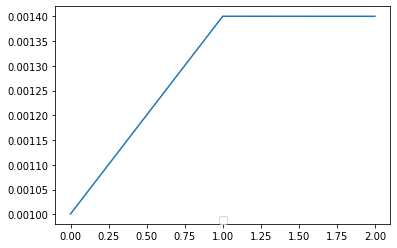

In [26]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt
 

def plot_history(fscores):
    max_f = np.max(np.array(fscores))
    print("History:", fscores)
    print("Highest f-score:", max_f)
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

In [56]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [27]:
model1.save("NEWModel1_Adam0.001.h5")

## 1.2 Expand context

Modify your network in such way that it is able to utilize the surrounding context of the word. This can be done for instance with a convolutional or recurrent layer. Analyze different neural network architectures and hyperparameters. How does utilizing the surrounding context influence the predictions?


In [29]:
#expanding to RNN model with context

from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 50

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = LSTM(rnn_size, activation='relu', return_sequences=True)(embeddings)
    outp=TimeDistributed(Dense(class_count, activation="softmax"))(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [30]:
print(rnn_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 168)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 50)           70200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 168, 37)           1887      
Total params: 15,072,687
Trainable params: 72,087
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [ ]:
optimizer=Adam(lr=1e-10) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10


In [50]:
#expanding to RNN model with context

from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 50

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    #embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = Bidirectional(LSTM(rnn_size, activation='relu', return_sequences=True))(inp)
    outp=TimeDistributed(Dense(class_count, activation="softmax"))(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

ValueError: Input 0 is incompatible with layer bidirectional_1: expected ndim=3, found ndim=2

In [39]:
rnn_model.save("CRAP2.h5")

In [ ]:
%matplotlib inline

plot_history(evaluation_function.fscore)

## 2.1 Use deep contextual representations

Use deep contextual representations. Fine-tune the embeddings with different hyperparameters. Try different models (e.g. cased and uncased, multilingual BERT). Report your results.


## 2.2 Error analysis

Select one model from each of the previous milestones (three models in total). Look at the entities these models predict. Analyze the errors made. Are there any patterns? How do the errors one model makes differ from those made by another?

Simple RNN

In [46]:
#I want to see how the model predicts classes


# Recreate the exact same rnn, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.models import load_model

simple_rnn = tf.keras.models.load_model('Model1_Adam.h5')

# Show the model architecture
simple_rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
dense_10 (Dense)             (None, 168, 50)           15050     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 168, 37)           1887      
Total params: 15,017,537
Trainable params: 16,937
Non-trainable params: 15,000,600
_________________________________________________________________


In [32]:
simple_rnn_predictions = simple_rnn.predict(vectorized_data_padded)  #save predictions

In [33]:
simple_rnn_predictions[0][0]   #see what the output looks like
#The outputs are probabilities for each class (tag)

array([1.00923516e-03, 3.70084337e-04, 2.46811518e-03, 1.86059671e-03,
       1.80526462e-03, 1.96474921e-02, 1.98890315e-03, 3.88048938e-04,
       3.46431532e-03, 8.96527991e-03, 1.16933300e-03, 2.04792549e-03,
       2.45094928e-03, 1.23758800e-02, 1.77301303e-03, 8.77117636e-05,
       5.58422646e-04, 1.65068393e-03, 2.11346359e-03, 2.18506940e-02,
       5.83406836e-05, 1.00549106e-02, 1.00687124e-07, 1.56564042e-02,
       2.50884541e-03, 8.49931955e-01, 1.56020680e-02, 2.94749867e-07,
       1.32280961e-03, 1.38389622e-03, 1.98811502e-03, 3.84029234e-03,
       2.17660354e-03, 4.04416234e-04, 3.41106812e-03, 1.84880418e-03,
       1.76567317e-03], dtype=float32)

In [34]:
import numpy as np


list_of_tag_args = []    #create a list of saved positions for each entity label
for i in simple_rnn_predictions:
    for j in i:
        temp = np.argmax(j)
        list_of_tag_args.append(temp)

In [35]:
list_of_tag_args  #Now that we have this list, we can use our label map dictionary to identify the actual tag

[25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,


In [42]:
type(list_of_tag_args[0])

numpy.int64

LSTM

In [40]:
#I want to see how the model predicts classes


# Recreate the exact same lstm, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.models import load_model

lstm = tf.keras.models.load_model('CRAP2.h5')   #This model has an f-score of 0.99

# Show the model architecture
lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 50)           70200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 168, 37)           1887      
Total params: 15,072,687
Trainable params: 72,087
Non-trainable params: 15,000,600
_________________________________________________________________


In [41]:
lstm_predictions = lstm.predict(vectorized_data_padded)  #save predictions

In [42]:
lstm_predictions[0][0]   #see what the output looks like
#The outputs are probabilities for each class (tag)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)

In [40]:
list_of_lstm_tag_args = []    #create a list of saved positions for each entity label
for i in lstm_predictions:
    for j in i:
        temp = np.argmax(j)
        list_of_lstm_tag_args.append(temp)

In [43]:
list_of_lstm_tag_args  #Now that we have this list, we can use our label map dictionary to identify the actual tag

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## 3.1 Predictions on unannotated text

Use the three models selected in milestone 2.2 to do predictions on the sampled wikipedia text.

## 3.2 Statistically analyze the results

Statistically analyze (i.e. count the number of instances) and compare the predictions. You can, for example, analyze if some models tend to predict more entities starting with a capital letter, or if some models predict more entities for some specific classes than others.